# Gestructureerde data: preprocessing dataset

In dit voorbeeld gaan we verder werken op de titanic dataset bestudeerd in voorgaande notebook.
Hierbij gaan we preprocessing toevoegen of in meer detail bespreken.

Hierbij is een belangrijk onderscheid tussen pytorch en tensorflow op te merken. Hierbij is het belangrijk om te realiseren dat pytorch verwacht dat alle data dat uit de __get__item functie komt numeriek is. Deze moet niet noodzakelijk reeds geschaald zijn maar moet wel dat datatype hebben. Het is dus belangrijk om een goede keuze te maken op welke plaats de nodige preprocessing stappen uitgevoerd worden. 
In het geval van tensorflow (in het geval van mixed datatypes) plaatsen we van in het begin elke feature apart. Daarna voegen we gelijkaardige features samen om deze te preprocessen. Pas op het einde van dit proces worden alle features samengevoegd tot een numerieke tensor.

### Pytorch

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load Titanic dataset
titanic = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
display(titanic)

# Define the preprocessing pipeline
numeric_features = ['age', 'n_siblings_spouses', 'parch', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['sex', 'class', 'embark_town', 'deck', 'alone']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define custom PyTorch Dataset
class TitanicDataset(Dataset):
    def __init__(self, dataframe, preprocessor, train=True):
        # Separate features and target
        self.X = dataframe.drop('survived', axis=1)
        
        self.preprocessor = preprocessor        
        if train:
            preprocessor.fit(self.X)
        self.X = torch.tensor(preprocessor.transform(self.X), dtype=torch.float32)
        
        y = dataframe['survived']
        self.y = torch.tensor(y.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Train test
titanic_train = titanic.sample(frac=0.8)
titanic_test = titanic.drop(titanic_train.index)

# Create the dataset
dataset_train = TitanicDataset(titanic_train, preprocessor)
dataset_test = TitanicDataset(titanic_test, preprocessor, train=False)

# Create dataloaders
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
...,...,...,...,...,...,...,...,...,...,...
622,0,male,28.0,0,0,10.5000,Second,unknown,Southampton,y
623,0,male,25.0,0,0,7.0500,Third,unknown,Southampton,y
624,1,female,19.0,0,0,30.0000,First,B,Southampton,y
625,0,female,28.0,1,2,23.4500,Third,unknown,Southampton,n


### Keras/Tensorflow

Dit stukje is de meest complexe vorm om data in te laden maar misschien ook het meest flexible.
We gaan namelijk van een dataset met mixed types een sequentieel model maken waarbij de nodige preprocessing stappen aanwezig zijn in het model.
Dit gaat uiteindelijk leiden tot een vrij complexe modelopbouw.

Omdat preprocessing functionaliteiten slechts in de volgende stap gaan bestudeerd worden gaan we hier enkel kijken hoe we de data kunnen klaar zetten.
De twee methodes hiervoor zijn:
* Plaats elke input/feature in een apart Input object. Dit zijn symbolische tensors die gebruikt worden als placeholder voor onze data
* Maak een csv dataset (identiek als hierboven)

I0000 00:00:1728051449.097238    2664 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-04 14:17:29.098552: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


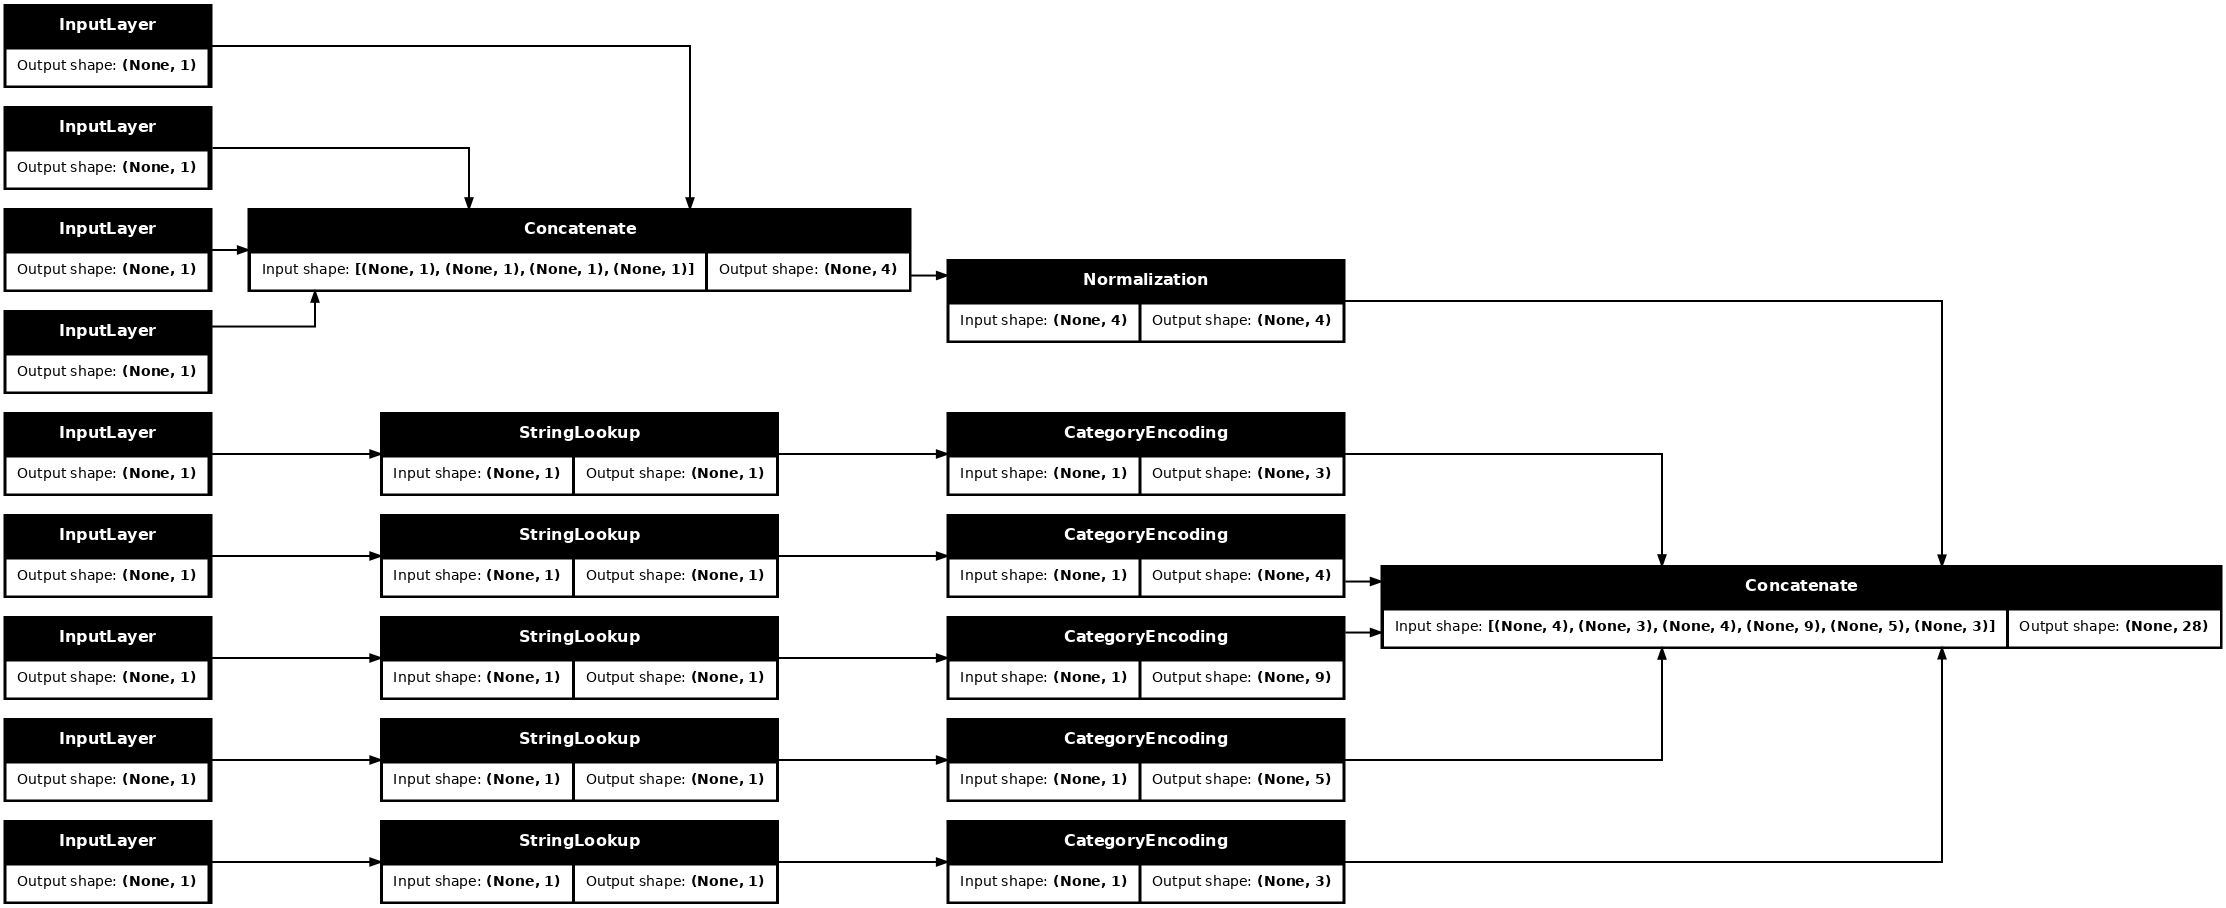

In [3]:
import numpy as np
import tensorflow as tf
from keras import Input
from keras import layers

import os
os.environ["KERAS_BACKEND"] = "torch" # keras maakt gebruik van pytorch

titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')

inputs = {}

for name, column in titanic_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = Input(shape=(1,), name=name, dtype=dtype)

inputs

# selecteer gelijkaardige inputs
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}
categoric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.string}

# om alle verschillende eindresultaten bij te houden
preprocessed_inputs = []

# preprocess numeriek
x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))

preprocessed_inputs.append(norm(x))

# preprocess categoriek
for name, input in categoric_inputs.items():
  lookup = layers.StringLookup(vocabulary=np.unique(titanic_features[name]))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
    
  preprocessed_inputs.append(x)

# voeg alle verwerkte inputs samen
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

## Oefening: Inkomensdataset

Met onderstaande code downloaden we een csv met gegevens rond het inkomen van volwassenen.
Plaats in de code-cellen eronder de nodige code om de volgende preprocessingstappen uit te voeren met zowel pytorch als tensorflow:

* Splits in train-test
* Label kolom is het inkomen -> voer hiervoor ordinal encoding uit
* Voer normalisatie uit van de numerieke kolommen zodat alle waarden tussen 0 en 1 liggen (geen standaardverdeling)
* Voer ordinal encoding uit op de occupation en native_country kolom
* Voer one-hot encoding uit op de overige niet-numerieke kolommen

In [30]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 
           'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 
           'hours_per_week', 'native_country', 'income']
adult_income = pd.read_csv(url, header=None, names=columns)

adult_income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [1]:
# pytorch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from torch.utils.data import Dataset
import torch

class AdultIncomeDataset(Dataset):
    def __init__(self, data, scaler=None, ordinal_enc=None, onehot_enc=None, train=True):
        columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 
                   'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 
                   'hours_per_week', 'native_country', 'income']
        
        # Load and set up columns
        self.data = pd.read_csv(data, header=None, names=columns)
        
        # Identify the columns
        self.numerical_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
        self.ordinal_cols = ['occupation', 'native_country']
        self.onehot_cols = ['workclass', 'education', 'marital_status', 'relationship', 'race', 'sex']
        
        # Ordinal encoding for 'income' (target label)
        income_enc = OrdinalEncoder(categories=[[' <=50K', ' >50K']])
        self.data['income'] = income_enc.fit_transform(self.data[['income']])

        # Normalize numerical columns (MinMaxScaler)
        if scaler is None:
            self.scaler = MinMaxScaler()
            self.data[self.numerical_cols] = self.scaler.fit_transform(self.data[self.numerical_cols])
        else:
            self.scaler = scaler
            self.data[self.numerical_cols] = self.scaler.transform(self.data[self.numerical_cols])
        
        # Ordinal encoding for specific columns
        if ordinal_enc is None:
            self.ordinal_enc = OrdinalEncoder()
            self.data[self.ordinal_cols] = self.ordinal_enc.fit_transform(self.data[self.ordinal_cols])
        else:
            self.ordinal_enc = ordinal_enc
            self.data[self.ordinal_cols] = self.ordinal_enc.transform(self.data[self.ordinal_cols])
        
        # One-hot encoding for categorical columns
        if onehot_enc is None:
            self.onehot_enc = OneHotEncoder(sparse=False, drop='first')
            onehot_encoded = self.onehot_enc.fit_transform(self.data[self.onehot_cols])
        else:
            self.onehot_enc = onehot_enc
            onehot_encoded = self.onehot_enc.transform(self.data[self.onehot_cols])
        
        # Combine data
        self.data = pd.concat([self.data.drop(columns=self.onehot_cols), 
                               pd.DataFrame(onehot_encoded, index=self.data.index)], axis=1)
        
        # Separate features and labels
        self.X = self.data.drop(columns='income').values
        self.y = self.data['income'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return X, y


In [2]:
# tensorflow